<a href="https://colab.research.google.com/github/Blaze-coder3/Bharat-Intern/blob/Movie-Recommendation/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

Put the Dataset Location

In [49]:
credits = pd.read_csv(r'C:\Users\syedk\Downloads\Bharat-Intern\Movie Recommendation\tmdb_5000_credits.csv')
movies = pd.read_csv(r'C:\Users\syedk\Downloads\Bharat-Intern\Movie Recommendation\tmdb_5000_movies.csv')

Step 1: Verify columns in the movies DataFrame

In [50]:

print(movies.columns)

# If the column name is 'Genres' instead of 'genres', adjust it in the following steps accordingly.

# Merge the dataframes based on the movie ID
df = credits.merge(movies, left_on='movie_id', right_on='id')

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


In [51]:
%pip install ast

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      Traceback (most recent call last):
        File "c:\Users\syedk\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\syedk\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\syedk\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\syedk\AppData\Local\Temp\pip-build-env-05kqthkn\


  Using cached AST-0.0.2.tar.gz (19 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


Define utility functions

In [52]:
import ast
def get_features(cast):
    output = []
    for x in ast.literal_eval(cast):
        output.append(x.get('name'))
    return np.unique(np.array(output)).tolist()

def get_director(crew):
    for member in ast.literal_eval(crew):
        if member.get('job') == 'Director':
            return member.get('name')
    return 'Unknown'

In [53]:
# Extract director information
credits['Director'] = credits['crew'].apply(lambda x: get_director(x))
credits.drop(columns=['crew'], inplace=True)
credits['Director'].fillna('Unknown', inplace=True)

# Create binary columns for director
credits_dummies = pd.get_dummies(credits['Director'].apply(pd.Series).stack()).astype(int)
credits = pd.concat([credits, credits_dummies], axis=1)
credits.drop(columns=['cast'], inplace=True)

Step 2: Create dummy variables for the correct column name (e.g., 'genres' or 'Genres')

In [54]:

movies_dummies = pd.get_dummies(movies['genres'].apply(pd.Series).stack()).astype(int)
movies_dummies.reset_index(drop=True, inplace=True)

# Reset the index of the movies DataFrame for concatenation
movies.reset_index(drop=True, inplace=True)

# Concatenate the dummy columns with the original DataFrame
movies = pd.concat([movies, movies_dummies], axis=1)

# Drop the original genres column since we now have dummy variables
movies.drop(columns=['genres'], inplace=True)

# Fill missing values in the merged dataframe
df.fillna(0, inplace=True)

# Compute average runtime for movies with valid runtime
avg_runtime = df.loc[df['runtime'] > 0, 'runtime'].mean()

# Replace 0 runtimes with the computed average
df['runtime'] = df['runtime'].apply(lambda x: avg_runtime if x == 0 else x)



Visualization

C:\Users\syedk\AppData\Local\Temp\ipykernel_17132\1221313271.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')


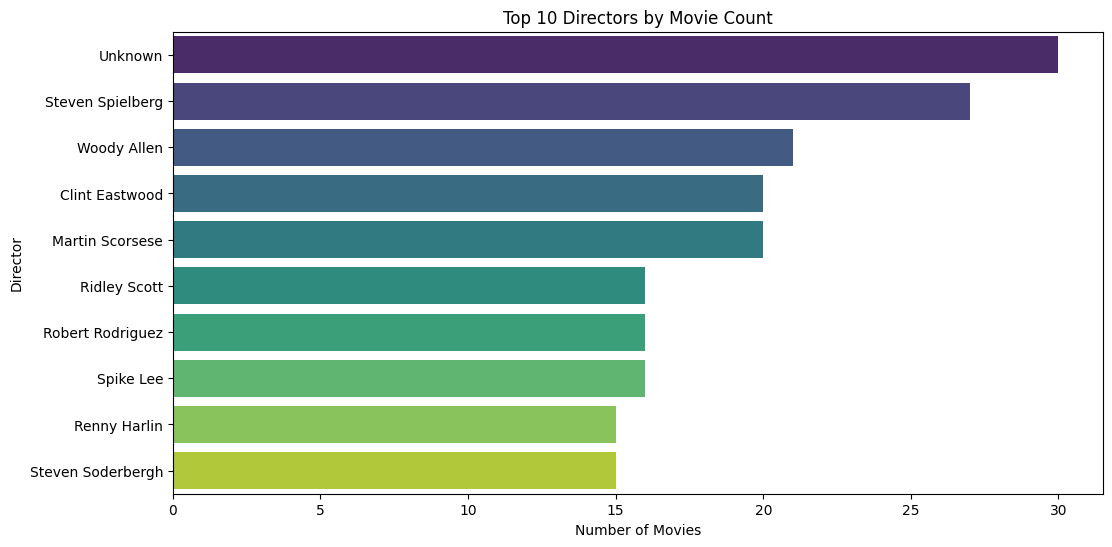

In [55]:
# Visualization 1: Bar Chart for Top 10 Directors by Movie Count
top_directors = credits['Director'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')
plt.title('Top 10 Directors by Movie Count')
plt.xlabel('Number of Movies')
plt.ylabel('Director')
plt.show()

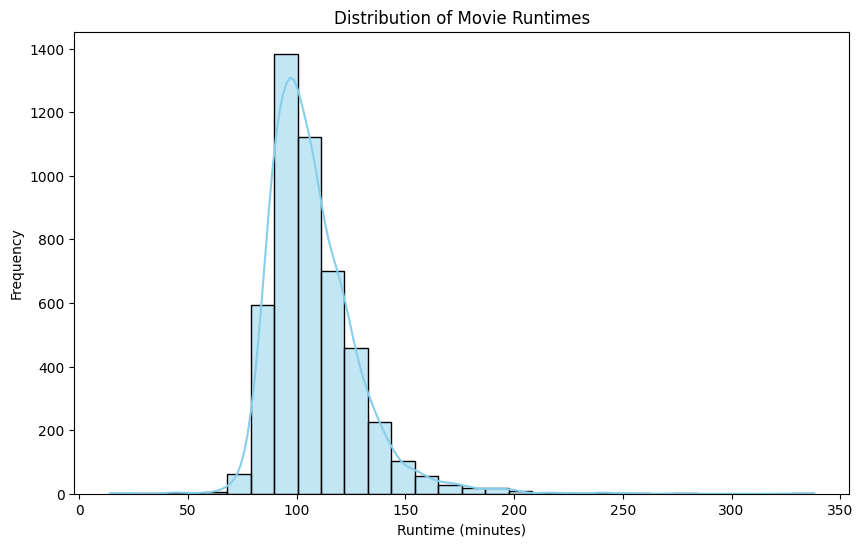

In [56]:
# Visualization 2: Histogram for Movie Runtimes
plt.figure(figsize=(10, 6))
sns.histplot(df['runtime'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()

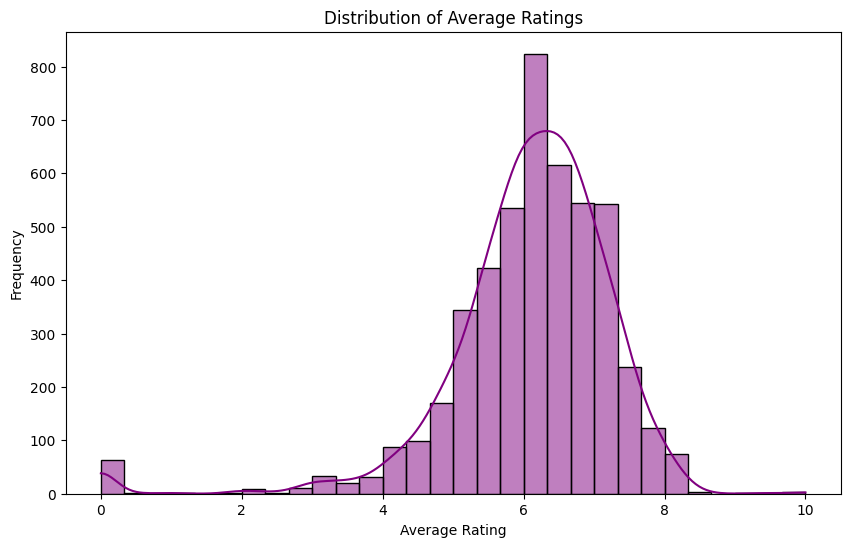

In [57]:
# Visualization 3: Distribution of Average Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_average'], bins=30, kde=True, color='purple')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


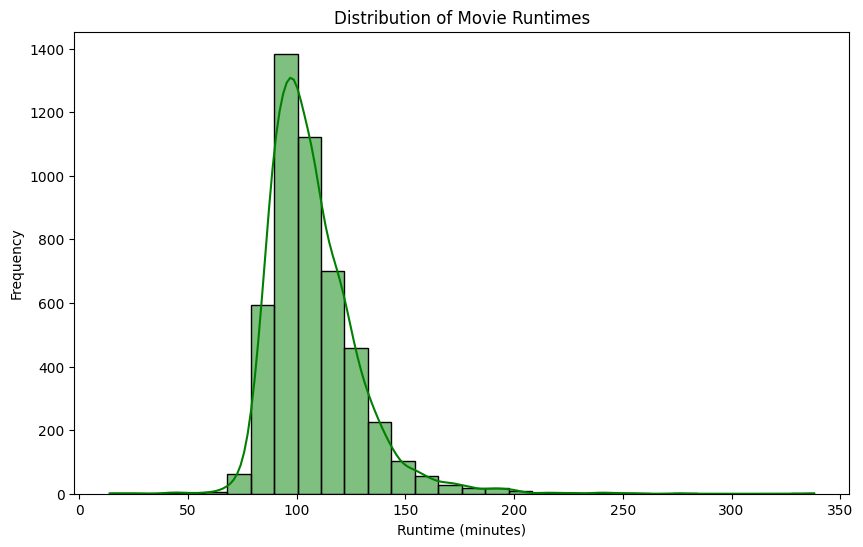

In [58]:
# Visualization 4: Distribution of Runtime
plt.figure(figsize=(10, 6))
sns.histplot(df['runtime'], bins=30, kde=True, color='green')
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()


In [59]:
# Check for duplicate movies
print(df['movie_id'].duplicated().sum())

# Display the first few rows of the merged dataframe
print(df.head())


0
   movie_id                                   title_x  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew     budget  \
0  [{"credit_id": "52fe48009251416c750aca23", "de...  237000000   
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  300000000   
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  245000000   
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de.

Extract & Save the Merged Dataset in CSV Format

In [60]:
import pandas as pd

# Read the CSV files
credits = pd.read_csv(r'C:\Users\syedk\Downloads\Bharat-Intern\Movie Recommendation\tmdb_5000_credits.csv')
movies = pd.read_csv(r'C:\Users\syedk\Downloads\Bharat-Intern\Movie Recommendation\tmdb_5000_movies.csv')

# Merge the datasets based on the movie ID column
merged_data = credits.merge(movies, left_on='movie_id', right_on='id', suffixes=('_credits', '_movies'))

# Save the merged dataset to a CSV file
merged_data.to_csv('merged_data.csv', index=False)


Check your DataFrame columns

In [61]:
print(df.columns)

Index(['movie_id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'id', 'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')


In [62]:
print(df.head())

   movie_id                                   title_x  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew     budget  \
0  [{"credit_id": "52fe48009251416c750aca23", "de...  237000000   
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  300000000   
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  245000000   
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...

In [63]:
def precision_at_k(actual, predicted, k):
    """
    Calculate precision at k.
    
    Parameters:
    - actual: List of actual items the user liked.
    - predicted: List of items recommended by the system.
    - k: Number of recommendations to consider.
    
    Returns:
    - Precision at k.
    """
    # Ensure that k is not greater than the number of items recommended
    k = min(k, len(predicted))
    
    # Consider only top-k recommendations
    predicted = predicted[:k]
    
    # Calculate the number of items relevant to the user
    relevant_items = set(actual)
    
    # Calculate the number of recommended items that are relevant
    num_relevant_at_k = len(set(predicted).intersection(relevant_items))
    
    # Calculate precision at k
    precision = num_relevant_at_k / k
    
    return precision

# Example usage:
actual_items = [1, 3, 5]  # Actual items the user liked
recommended_items = [1, 2, 3, 4, 5]  # Items recommended by the system

k = 10  # Consider top-3 recommendations

print(f"Precision at {k}: {precision_at_k(actual_items, recommended_items, k)}")


Precision at 10: 0.6
